In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import csv
import os
from bmtool.util import util
from bmtk.simulator import bionet

from analysis import plot # imoporting analysis module enables import from model folder
from build_input import get_populations, get_stim_cycle, t_start, on_time, off_time

TRIAL_NAME = "baseline"
RESULT_PATH = "simulation_results"
TRIAL_PATH = os.path.join(RESULT_PATH, TRIAL_NAME)
TRIAL_PATH = 'outputECP1'
INPUT_PATH = os.path.join('..', 'input')

--No graphics will be displayed.


ModuleNotFoundError: No module named 'Analysis'

In [ ]:
isbaseline = 'baseline' in TRIAL_NAME
if isbaseline:
    config = 'simulation_configECP_vpsi_homogenous.json'
elif 'const' in TRIAL_NAME:
    config = 'config_const.json'
else:
    config = 'config_short.json' if 'short' in TRIAL_NAME else 'config_long.json'

spike_file = os.path.join('..', TRIAL_PATH, 'spikes.h5')
config_file = os.path.join('..', config)

pop_color = plot.pop_color
pop_names = plot.pop_names

### Spike Raster

In [ ]:
conf = bionet.Config.from_json(config_file)
t_stop = conf['run']['tstop'] / 1000

nodes = util.load_nodes_from_config(config_file)
network_name = 'BLA'
cortex_df = nodes[network_name]
with h5py.File(spike_file) as f:
    spikes_df = pd.DataFrame({
        'node_ids': f['spikes'][network_name]['node_ids'],
        'timestamps': f['spikes'][network_name]['timestamps']
    })
    spikes_df.sort_values(by='timestamps', inplace=True, ignore_index=True)

In [ ]:
if isbaseline:
    id_column = 'node_ids'
else:
    id_column = 'sorted_id'
    with open(os.path.join(INPUT_PATH, 'Assembly_ids.csv'), 'r') as f:
        assembly_ids = [np.array(list(map(int, row)), dtype='uint64') for row in csv.reader(f)]
        thal_ids = assembly_ids[:len(assembly_ids) // 2]
        assembly_ids = assembly_ids[len(assembly_ids) // 2:]

    node_ids = cortex_df.index.values
    non_assy_ids = np.array(sorted(set(node_ids).difference(set(np.concatenate(assembly_ids)))))
    assembly_list = assembly_ids + [non_assy_ids,]
    num_5A = node_ids.size // 2
    sorted_assy = [[], []] # 5A and 5B
    for assy in assembly_list:
        idx_5A = assy < num_5A
        sorted_assy[0].append(assy[idx_5A])
        sorted_assy[1].append(assy[~idx_5A])

    sorted_ids = np.zeros_like(node_ids)
    for i, node_id in enumerate(np.concatenate(sorted_assy[0] + sorted_assy[1])):
        sorted_ids[node_id] = i
    cortex_df['sorted_id'] = sorted_ids
    spikes_df['sorted_id'] = cortex_df.loc[spikes_df['node_ids'], 'sorted_id'].values

In [ ]:
if not isbaseline:
    t_cycle, n_cycle = get_stim_cycle(on_time, off_time, t_start, t_stop)
    window = t_start + np.array([[0, on_time]])
    windows = (window + t_cycle * np.arange(n_cycle).reshape(n_cycle, 1))
else:
    windows = np.array([[0., t_stop]])

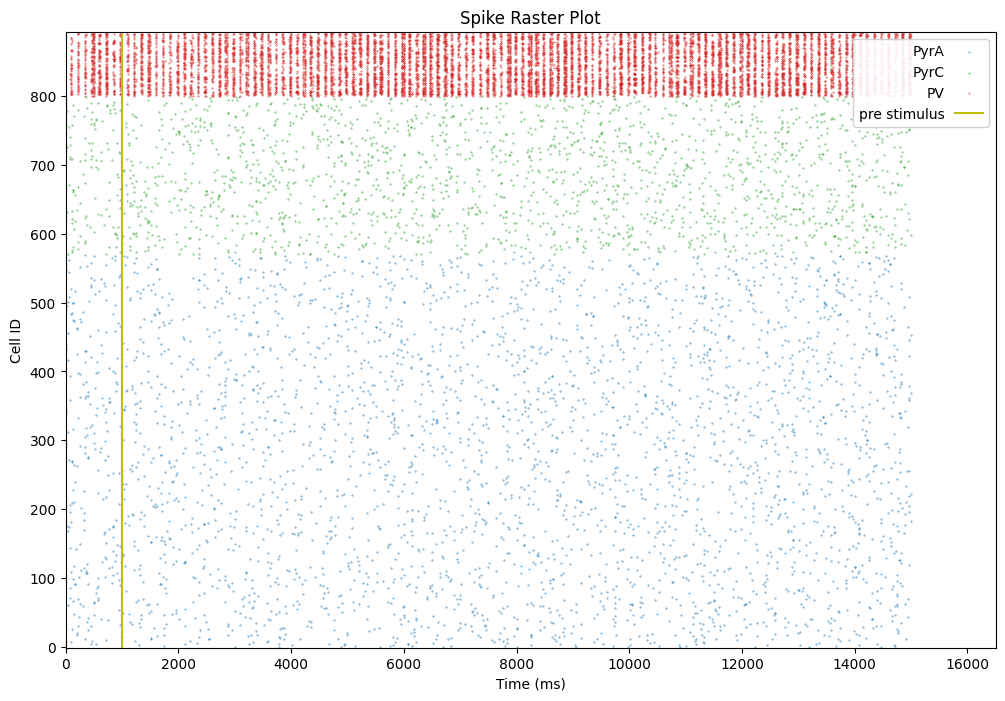

In [ ]:
# %matplotlib notebook

spikes_df['pop_name'] = cortex_df.loc[spikes_df['node_ids'], 'pop_name'].values
pop_spike = get_populations(spikes_df, pop_names)

_, ax = plt.subplots(1, 1, figsize=(12, 8))
plot.raster(pop_spike, pop_color, id_column=id_column, ax=ax)
ax.axvline(t_start * 1000, color='y', label='pre stimulus')
if not isbaseline:
    for win in windows:
        ax.axvline(win[0] * 1000, color='white', alpha=0.5)
        ax.axvline(win[1] * 1000, color='orange', alpha=0.5)
    ax.set_ylabel('Sorted ID by Assembly')
ax.legend(loc='upper right', framealpha=0.9, markerfirst=False)
ax.set_xlim([0, 1.1 * spikes_df['timestamps'].max()])
ax.set_ylim([cortex_df.index.min() - 1, cortex_df.index.max() + 1])
plt.show()

### Firing Rate

In [ ]:
frs = plot.firing_rate(spikes_df, num_cells=len(cortex_df), time_windows=windows)
Cortex_nodes = get_populations(cortex_df, pop_names, only_id=True)
pop_fr = {p: frs[nid] for p, nid in Cortex_nodes.items()}

if not isbaseline:
    print('Stimulus on time: ')

print('Firing rate: mean, std')
for p, fr in pop_fr.items():
    print(f'{p}: {fr.mean():.3g}, {fr.std():.3g}')

Firing rate: mean, std
PyrA: 0.398, 0.142
PyrC: 0.579, 0.243
PV: 7.43, 2.35
SOM: nan, nan
CR: nan, nan


/home/gjgpb9/AmygdalaTheta-logan/Analysis/analysis/plot.py:80: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not spikes_df['timestamps'].is_monotonic:
/tmp/ipykernel_1284534/1647752651.py:10: RuntimeWarning: Mean of empty slice.
  print(f'{p}: {fr.mean():.3g}, {fr.std():.3g}')
/home/gjgpb9/miniconda3/envs/oldNeuron/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gjgpb9/miniconda3/envs/oldNeuron/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/gjgpb9/miniconda3/envs/oldNeuron/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/gjgpb9/miniconda3/env

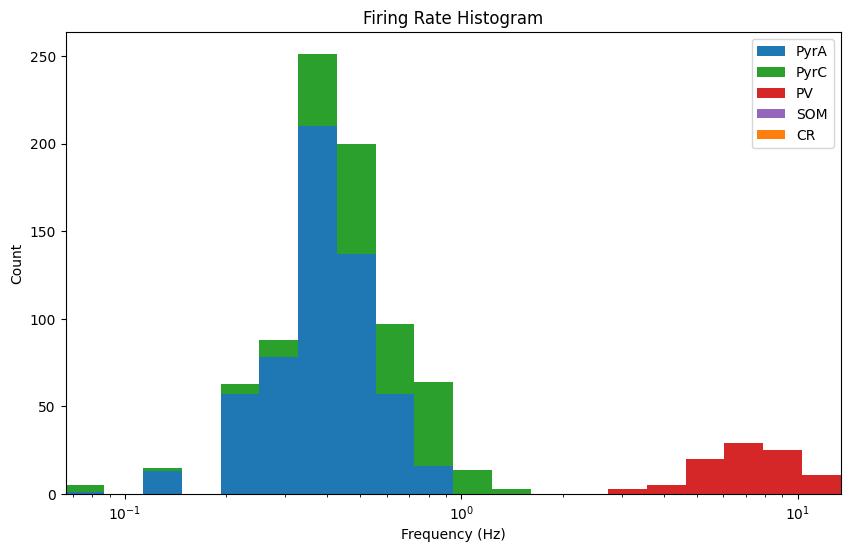

In [ ]:
%matplotlib inline

min_fr = 0.5 / plot.total_duration(windows)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot.firing_rate_histogram(pop_fr, pop_color, bins=20, min_fr=min_fr,
                      logscale=True, stacked=True, ax=ax)
plt.show()

### Population spike rate

In [ ]:
fs = 2000.
dt = 1000 / fs
time = np.array([0, 1000 * t_stop, dt])
pop_rspk = {p: plot.pop_spike_rate(spk['timestamps'], time) for p, spk in pop_spike.items()}

In [ ]:
SAVE_PATH = os.path.join('..',TRIAL_PATH, 'spike_rate.h5')

with h5py.File(SAVE_PATH, 'w') as f:
    f.create_dataset('time', data=time)
    grp = f.create_group('populations')
    for p, rspk in pop_rspk.items():
        pop = grp.create_group(p)
        pop.create_dataset('data', data=rspk)
        pop.attrs['number'] = len(Cortex_nodes[p])

### Calling plot functions directly

Plotting cortex spike raster


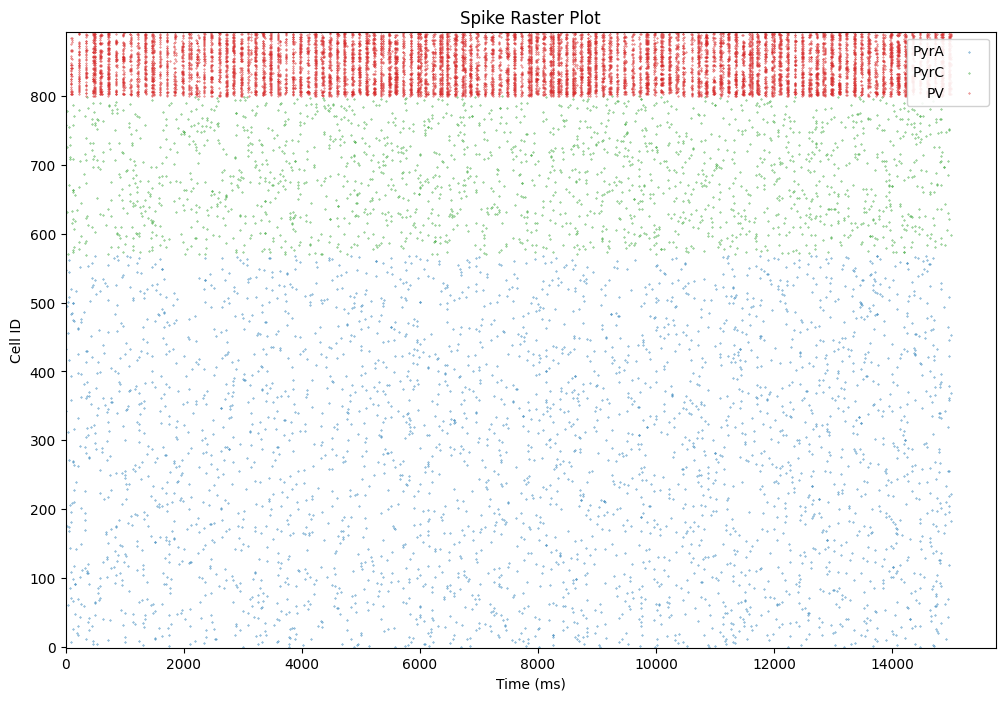

/home/gjgpb9/AmygdalaTheta-logan/Analysis/analysis/plot.py:80: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not spikes_df['timestamps'].is_monotonic:
/home/gjgpb9/AmygdalaTheta-logan/Analysis/analysis/plot.py:356: RuntimeWarning: Mean of empty slice.
  print(f'{p}: {fr.mean():.3g}, {fr.std():.3g}')
/home/gjgpb9/miniconda3/envs/oldNeuron/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gjgpb9/miniconda3/envs/oldNeuron/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/gjgpb9/miniconda3/envs/oldNeuron/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/hom

Firing rate: mean, std
PyrA: 0.398, 0.142
PyrC: 0.579, 0.243
PV: 7.43, 2.35
SOM: nan, nan
CR: nan, nan
Plotting firing rates


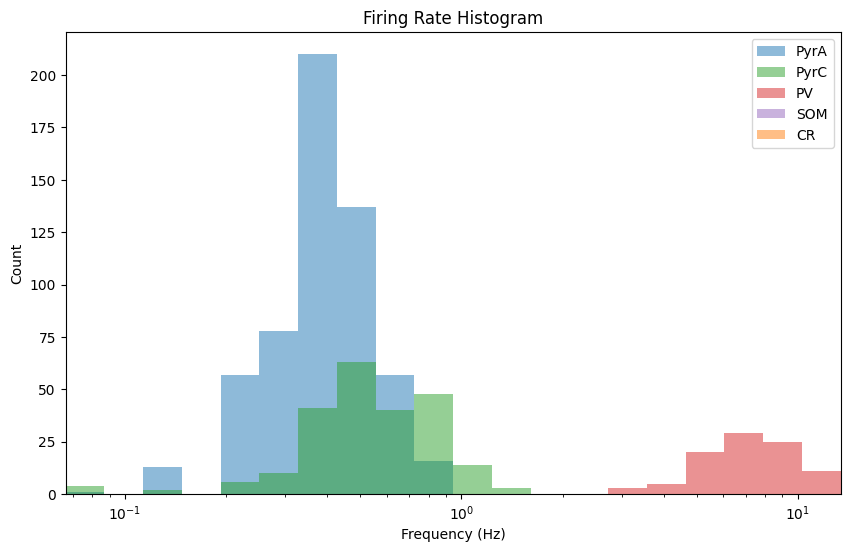

In [ ]:
pop_spike = plot.plot(choose=1, spike_file=spike_file, config=config, figsize=(12, 8))

if not isbaseline:
    print('On average: ')
frs = plot.plot(choose=2, spike_file=spike_file, figsize=(10, 6))